# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [933]:
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, 
                         get_open_orders, cancel_order,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import JP_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.timeseries import forecast_cone_bootstrap
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe

In [934]:
idx = pd.IndexSlice
sns.set_style('darkgrid')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [935]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [936]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [937]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

## Load Data

### Quandl Wiki Bundel

In [938]:
bundle_data = bundles.load('stooq')

### ML Predictions

In [939]:
def load_predictions(bundle):
    t = 1
    df = pd.concat([pd.read_hdf('predictions.h5', 'train/{:02}'.format(t)),
                    pd.read_hdf('predictions.h5', 'test/{:02}'.format(t))])
    df = df[~df.index.duplicated()].drop('y_test', axis=1)
    predictions = df.iloc[:, :5].mean(1).to_frame('predictions')

    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .predictions
            .tz_localize('UTC')), assets

In [940]:
predictions, assets = load_predictions(bundle_data)

In [941]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 2015-12-14 to 2019-12-27
Columns: 940 entries, 1 to 2856
dtypes: float64(940)
memory usage: 7.1 MB


### Define Custom Dataset

In [942]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = JP_EQUITIES

### Define Pipeline Loaders

In [943]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [944]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

### Create Pipeline

In [945]:
def compute_signals():
    signals = MLSignal()
    predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets)
    )

## Initialize Algorithm

In [946]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.05, min_trade_cost=1))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [947]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

## Define Rebalancing Logic

In [948]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [949]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [950]:
dates = predictions.index.get_level_values('date')
start_date = dates.min() + pd.DateOffset(day=1)
end_date = dates.max()

In [951]:
print('Start:\t{}\nEnd:\t{}'.format(start_date.date(), end_date.date()))

Start:	2015-12-01
End:	2019-12-27


In [952]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='stooq',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-02-27 02:01:55.697187]: WARNING: _load_cached_data: Refusing to download new benchmark data because a download succeeded at 2020-02-27 01:58:24.325813+00:00.
[2020-02-27 02:01:55.726241]: WARNING: _load_cached_data: Refusing to download new treasury data because a download succeeded at 2020-02-27 01:58:24.865812+00:00.
[2020-02-27 02:02:54.028136]: INFO: handle_simulation_end: Simulated 1026 trading days
first open: 2015-12-01 14:31:00+00:00
last close: 2019-12-27 21:00:00+00:00


Duration: 58.36s


## PyFolio Analysis

In [953]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [954]:
benchmark = web.DataReader('NIKKEI225', 'fred', '2015', '2020').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

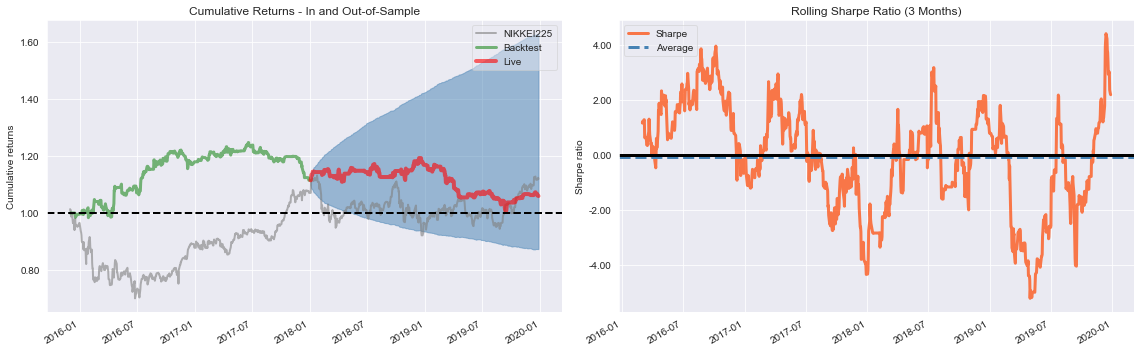

In [963]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2018-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig('figures/pyfolio_out_of_sample', dpi=300);

### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.13,2017-06-19,2019-09-13,NaT,NaN
1,5.91,2016-02-16,2016-04-08,2016-04-19,46
2,5.36,2016-11-17,2016-12-08,2017-04-10,103
3,3.53,2016-05-12,2016-05-27,2016-07-12,44
4,3.41,2016-01-27,2016-01-28,2016-02-16,15


Stress Events,mean,min,max
New Normal,0.01%,-3.41%,4.63%


Top 10 long positions of all time,max
sid,
9508.JP,16.11%
4587.JP,14.03%
6702.JP,13.05%
7013.JP,12.36%
4755.JP,12.21%
7532.JP,12.07%
3436.JP,11.67%
8113.JP,11.58%
4536.JP,11.45%


Top 10 short positions of all time,max
sid,
9508.JP,-20.18%
4587.JP,-18.60%
1808.JP,-13.52%
1925.JP,-13.43%
4324.JP,-12.77%
5019.JP,-11.85%
4689.JP,-11.84%
7701.JP,-11.82%
5232.JP,-11.68%


Top 10 positions of all time,max
sid,
9508.JP,20.18%
4587.JP,18.60%
1808.JP,13.52%
1925.JP,13.43%
6702.JP,13.05%
4324.JP,12.77%
7013.JP,12.36%
4755.JP,12.21%
7532.JP,12.07%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,17842.00,8935.00,8907.00
Percent profitable,0.49,0.49,0.49
Winning round_trips,8668.00,4340.00,4328.00
Losing round_trips,8688.00,4341.00,4347.00
Even round_trips,486.00,254.00,232.00


PnL stats,All trades,Short trades,Long trades
Total profit,$122616.04,$-178159.28,$300775.33
Gross profit,$6483816.58,$2997150.30,$3486666.28
Gross loss,$-6361200.53,$-3175309.58,$-3185890.95
Profit factor,$1.02,$0.94,$1.09
Avg. trade net profit,$6.87,$-19.94,$33.77
Avg. winning trade,$748.02,$690.59,$805.61
Avg. losing trade,$-732.18,$-731.47,$-732.89
Ratio Avg. Win:Avg. Loss,$1.02,$0.94,$1.10
Largest winning trade,$17226.46,$17226.46,$9165.00
Largest losing trade,$-18004.02,$-18004.02,$-10090.50


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 15:15:24.311119,1 days 15:05:34.816228,1 days 15:25:15.659144
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,10 days 00:00:00,10 days 00:00:00,7 days 00:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 20:59:59


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.00%
Avg returns winning,0.07%,0.06%,0.07%
Avg returns losing,-0.06%,-0.06%,-0.06%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.05%,0.04%,0.05%
Median returns losing,-0.04%,-0.04%,-0.04%
Largest winning trade,1.45%,1.45%,0.79%
Largest losing trade,-1.63%,-1.63%,-0.82%


Symbol stats,1332.JP,1377.JP,1379.JP,1407.JP,1414.JP,1417.JP,1605.JP,1662.JP,1719.JP,1720.JP,1721.JP,1766.JP,1801.JP,1802.JP,1803.JP,1805.JP,1808.JP,1812.JP,1813.JP,1815.JP,1820.JP,1821.JP,1822.JP,1824.JP,1833.JP,1835.JP,1860.JP,1861.JP,1878.JP,1881.JP,1883.JP,1885.JP,1890.JP,1893.JP,1911.JP,1925.JP,1926.JP,1928.JP,1941.JP,1942.JP,1944.JP,1950.JP,1951.JP,1959.JP,1963.JP,1968.JP,1969.JP,1973.JP,1979.JP,1983.JP,2001.JP,2002.JP,2109.JP,2120.JP,2124.JP,2127.JP,2138.JP,2146.JP,2151.JP,2157.JP,2168.JP,2170.JP,2174.JP,2175.JP,2181.JP,2193.JP,2201.JP,2206.JP,2212.JP,2220.JP,2222.JP,2229.JP,2264.JP,2267.JP,2269.JP,2270.JP,2281.JP,2282.JP,2317.JP,2326.JP,2327.JP,2331.JP,2337.JP,2353.JP,2362.JP,2371.JP,2379.JP,2384.JP,2389.JP,2395.JP,2398.JP,2412.JP,2413.JP,2427.JP,2428.JP,2429.JP,2432.JP,2433.JP,2440.JP,2461.JP,2484.JP,2489.JP,2491.JP,2492.JP,2501.JP,2502.JP,2503.JP,2531.JP,2579.JP,2587.JP,2590.JP,2593.JP,2602.JP,2607.JP,2651.JP,2659.JP,2664.JP,2670.JP,2678.JP,2681.JP,2685.JP,2695.JP,2702.JP,2706.JP,2726.JP,2730.JP,2768.JP,2782.JP,2784.JP,2801.JP,2802.JP,2809.JP,2810.JP,2811.JP,2815.JP,2871.JP,2875.JP,2897.JP,2914.JP,2918.JP,2931.JP,3002.JP,3003.JP,3028.JP,3034.JP,3038.JP,3046.JP,3048.JP,3050.JP,3064.JP,3076.JP,3086.JP,3087.JP,3088.JP,3091.JP,3092.JP,3097.JP,3098.JP,3099.JP,3101.JP,3103.JP,3104.JP,3105.JP,3107.JP,3110.JP,3116.JP,3141.JP,3148.JP,3156.JP,3179.JP,3186.JP,3231.JP,3244.JP,3250.JP,3254.JP,3284.JP,3288.JP,3289.JP,3291.JP,3333.JP,3341.JP,3349.JP,3360.JP,3382.JP,3387.JP,3391.JP,3395.JP,3397.JP,3401.JP,3402.JP,3405.JP,3407.JP,3433.JP,3436.JP,3443.JP,3569.JP,3591.JP,3593.JP,3626.JP,3632.JP,3635.JP,3649.JP,3655.JP,3657.JP,3659.JP,3660.JP,3662.JP,3665.JP,3673.JP,3676.JP,3678.JP,3738.JP,3756.JP,3762.JP,3765.JP,3769.JP,3774.JP,3793.JP,3844.JP,3857.JP,3861.JP,3863.JP,3865.JP,3880.JP,3941.JP,4004.JP,4005.JP,4008.JP,4021.JP,4023.JP,4028.JP,4041.JP,4042.JP,4043.JP,4044.JP,4045.JP,4047.JP,4061.JP,4062.JP,4063.JP,4088.JP,4091.JP,4095.JP,4109.JP,4112.JP,4114.JP,4118.JP,4151.JP,4182.JP,4183.JP,4185.JP,4186.JP,4188.JP,4202.JP,4203.JP,4204.JP,4205.JP,4206.JP,4208.JP,4217.JP,4272.JP,4282.JP,4290.JP,4301.JP,4307.JP,4321.JP,4324.JP,4343.JP,4348.JP,4368.JP,4401.JP,4403.JP,4452.JP,4461.JP,4471.JP,4502.JP,4503.JP,4506.JP,4507.JP,4508.JP,4514.JP,4516.JP,4519.JP,4521.JP,4523.JP,4527.JP,4528.JP,4530.JP,4534.JP,4536.JP,4540.JP,4541.JP,4543.JP,4544.JP,4547.JP,4548.JP,4549.JP,4552.JP,4553.JP,4555.JP,4559.JP,4568.JP,4569.JP,4571.JP,4578.JP,4581.JP,4587.JP,4612.JP,4613.JP,4617.JP,4626.JP,4631.JP,4633.JP,4634.JP,4661.JP,4665.JP,4666.JP,4676.JP,4680.JP,4681.JP,4684.JP,4686.JP,4689.JP,4694.JP,4704.JP,4708.JP,4714.JP,4716.JP,4732.JP,4733.JP,4739.JP,4751.JP,4755.JP,4768.JP,4812.JP,4813.JP,4819.JP,4848.JP,4849.JP,4901.JP,4902.JP,4911.JP,4912.JP,4917.JP,4919.JP,4921.JP,4922.JP,4927.JP,4928.JP,4967.JP,4971.JP,4974.JP,4975.JP,4978.JP,4996.JP,4997.JP,5017.JP,5019.JP,5020.JP,5101.JP,5108.JP,5110.JP,5122.JP,5191.JP,5201.JP,5202.JP,5208.JP,5214.JP,5232.JP,5233.JP,5301.JP,5302.JP,5310.JP,5332.JP,5333.JP,5334.JP,5344.JP,5384.JP,5393.JP,5401.JP,5406.JP,5410.JP,5411.JP,5423.JP,5440.JP,5444.JP,5451.JP,5463.JP,5471.JP,5480.JP,5481.JP,5482.JP,5486.JP,5541.JP,5563.JP,5631.JP,5703.JP,5706.JP,5707.JP,5711.JP,5713.JP,5714.JP,5715.JP,5726.JP,5727.JP,5741.JP,5801.JP,5802.JP,5803.JP,5809.JP,5851.JP,5857.JP,5901.JP,5911.JP,5912.JP,5929.JP,5930.JP,5932.JP,5943.JP,5947.JP,5949.JP,5975.JP,5991.JP,6005.JP,6013.JP,6050.JP,6055.JP,6058.JP,6077.JP,6080.JP,6088.JP,6101.JP,6103.JP,6104.JP,6113.JP,6118.JP,6134.JP,6135.JP,6136.JP,6140.JP,6141.JP,6146.JP,6201.JP,6222.JP,6250.JP,6256.JP,6258.JP,6268.JP,6269.JP,6273.JP,6282.JP,6284.JP,6287.JP,6289.JP,6301.JP,6302.JP,6305.JP,6310.JP,6315.JP,6324.JP,6326.JP,6330.JP,6340.JP,6349.JP,6361.JP,6366.JP,6367.JP,6370.JP,6371.JP,6376.JP,6383.JP,6390.JP,6395.JP,6406.JP,6407.JP,6409.JP,6412.JP,6417.JP,6418.JP,6425.JP,6432.JP,6436.JP,6440.JP,6444.JP,6448.JP,6457.JP,6460.JP,6463.JP,6465.JP,6471.JP,6472.JP,6473.JP,6474.JP,6479.JP,6480.JP,6481.JP,6498.JP,6501.JP,650

Profitability (PnL / PnL total) per name,
symbol,
6976.JP,24.30%
7261.JP,20.85%
3436.JP,14.98%
6502.JP,14.63%
2168.JP,13.38%
4587.JP,13.17%
8358.JP,12.67%
2413.JP,12.30%
4922.JP,12.02%


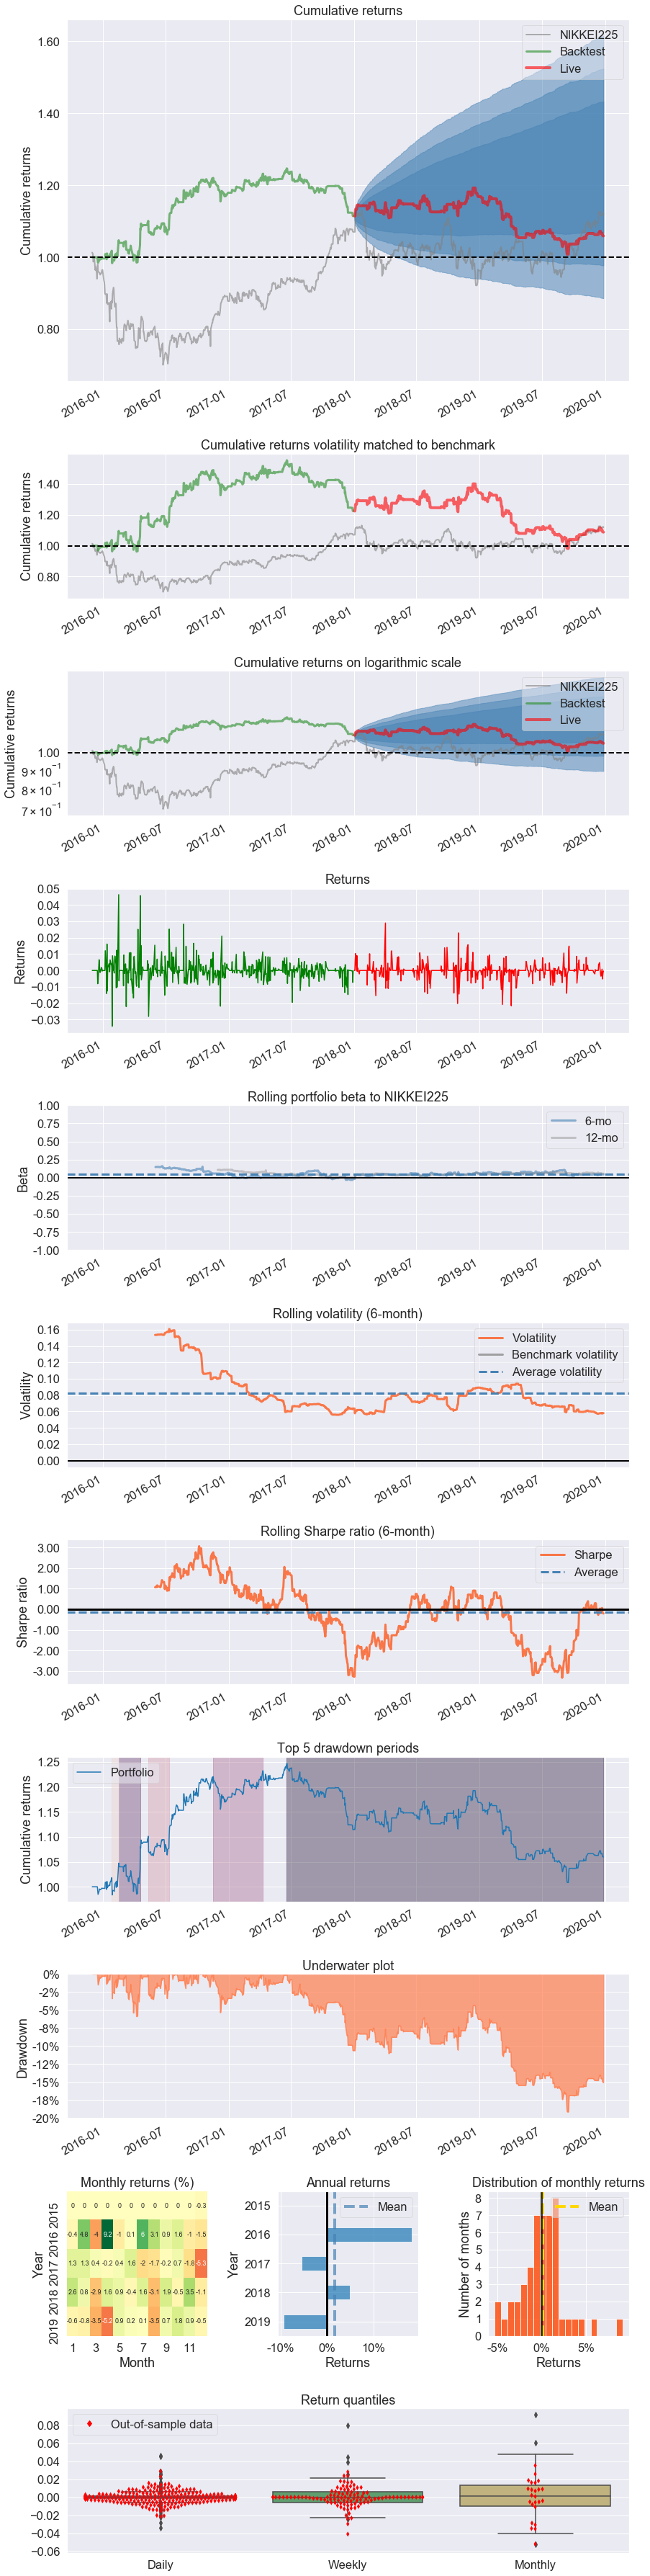

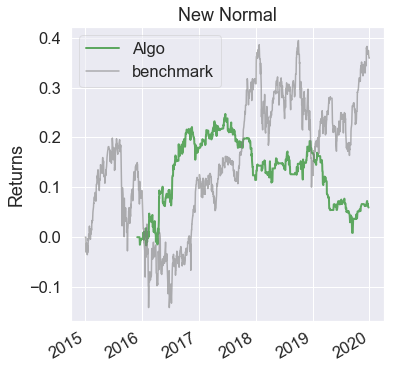

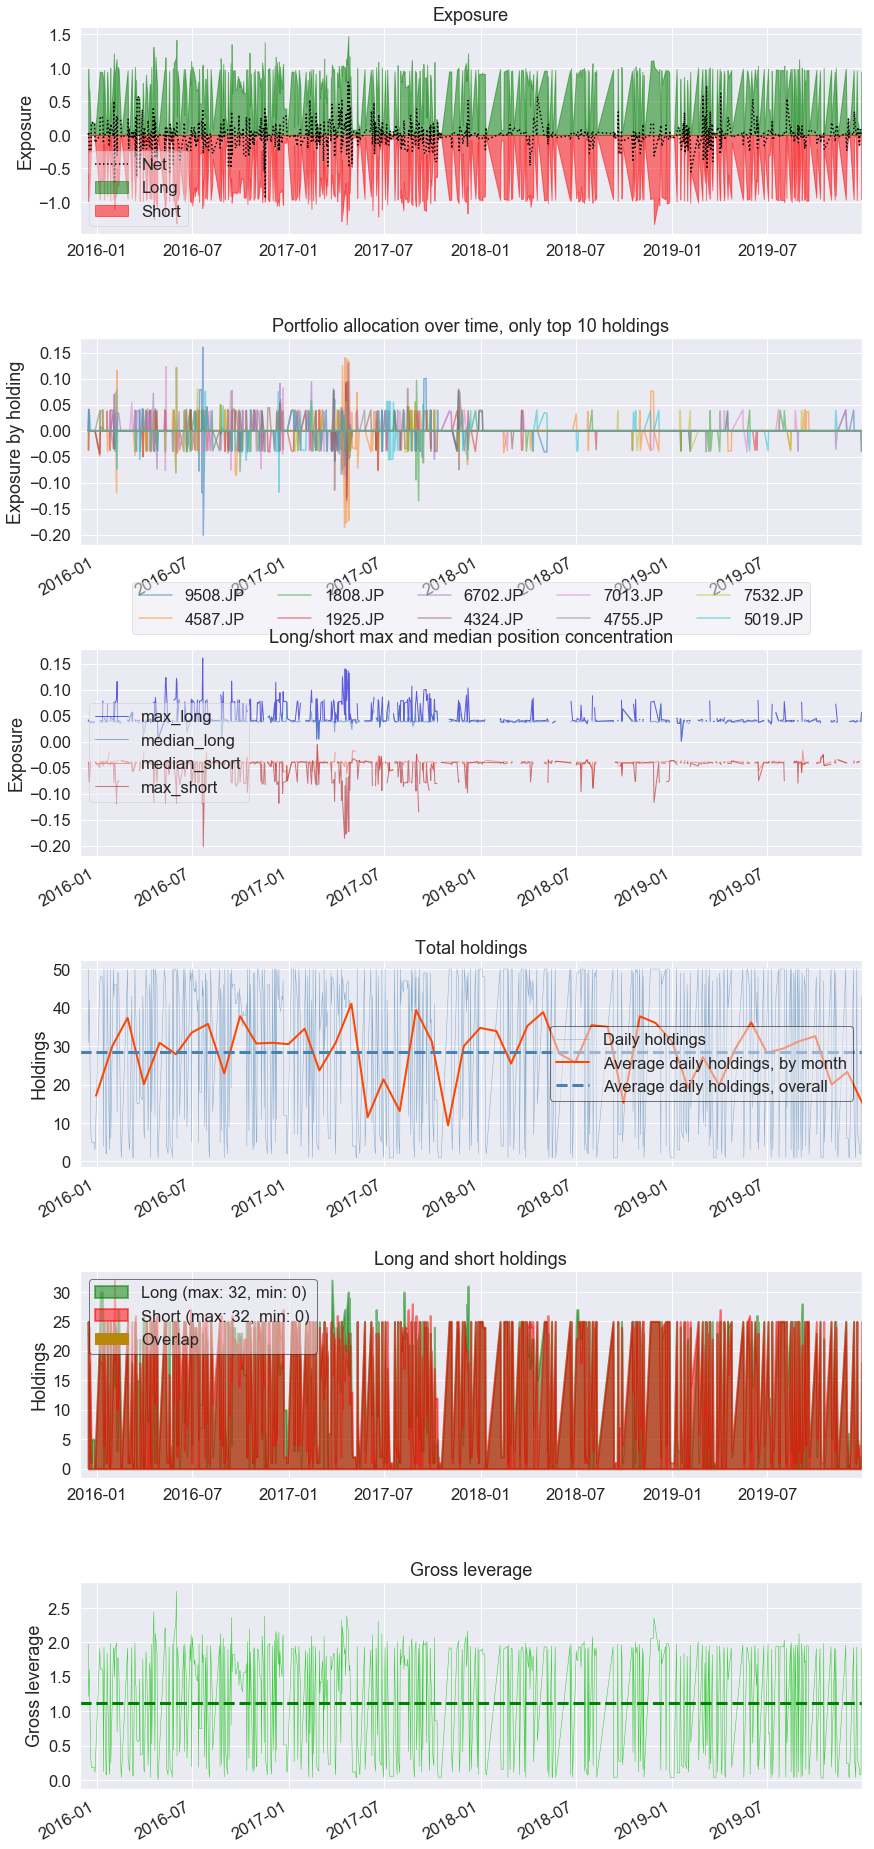

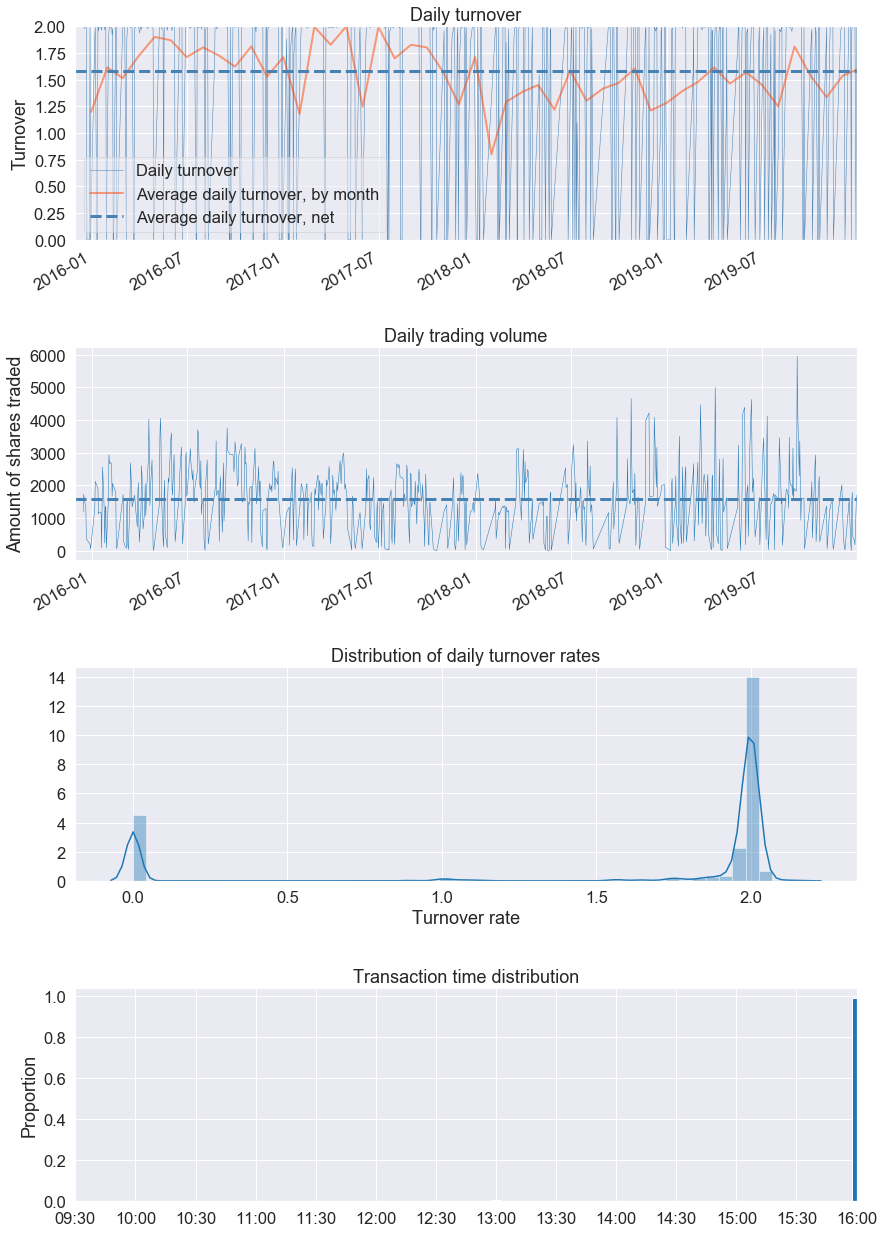

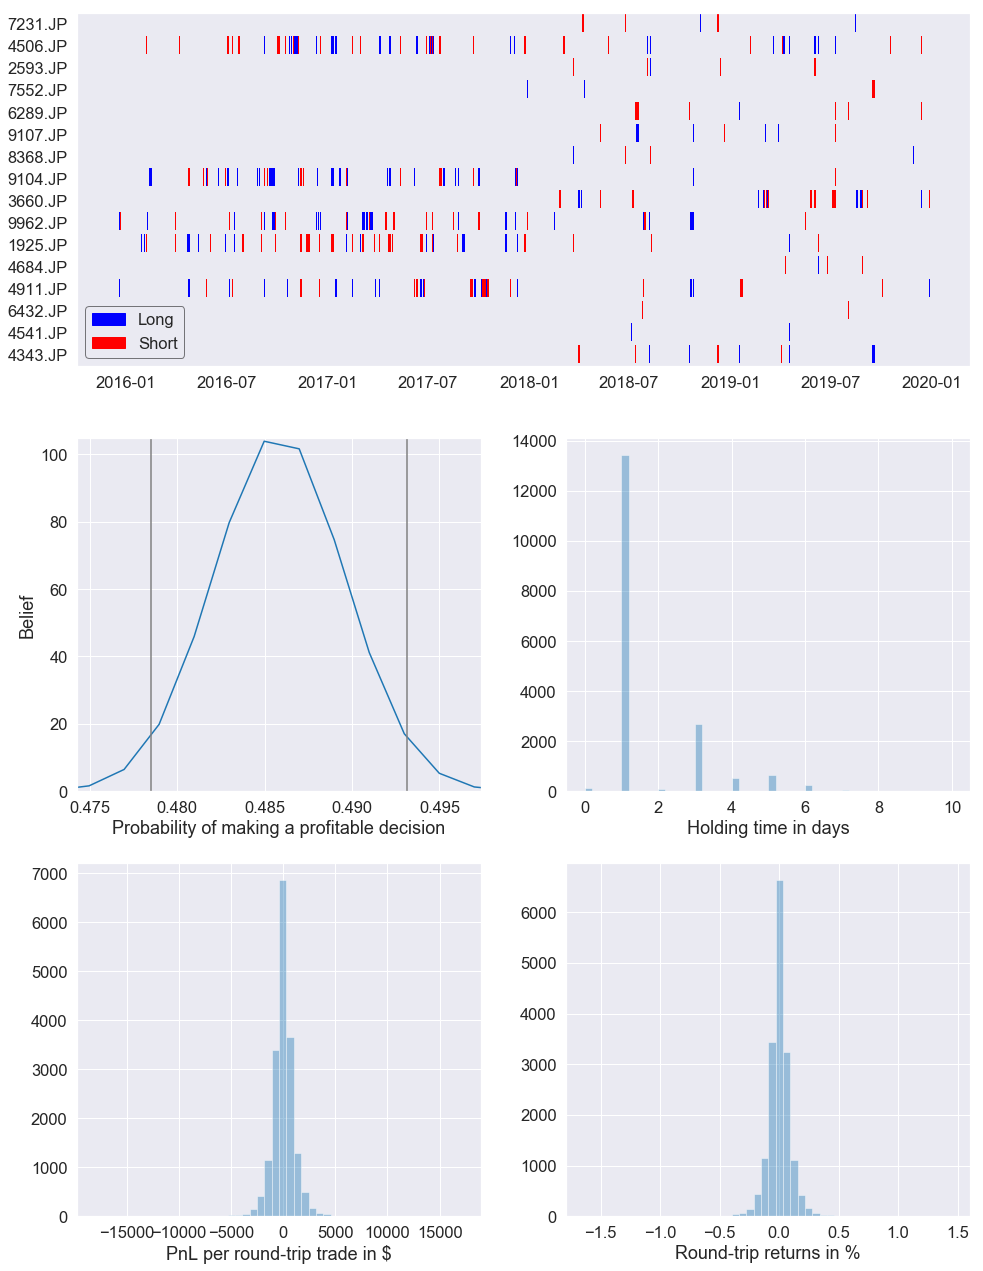

In [956]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2018-01-01', 
                          round_trips=True)